### Imports

In [1]:
import numpy as np

# %matplotlib notebook
from tqdm import tqdm
from matplotlib import pyplot as plt
import sys
import math
from mpl_toolkits import mplot3d
from pylab import rcParams
from tqdm import tqdm 
rcParams['figure.figsize'] = 10, 15

## Point To Point

### Data Plotting

In [2]:
'''Plot the true and moved data using Matplotlib'''
def plot_data(data_1, data_2, label_1, label_2, markersize_1=8, markersize_2=8):
    ax = plt.axes(projection='3d')
    ax.scatter3D(data_1[0,:], data_1[1,:], data_1[2,:], color='#336699', label=label_1)
    ax.scatter3D(data_2[0,:], data_2[1,:], data_2[2,:], color='orangered', label=label_2)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.legend()
    return ax

def plot_values(values, label):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(values, label=label)
    ax.legend()
    ax.grid(True)
    plt.show()

### Data Generation

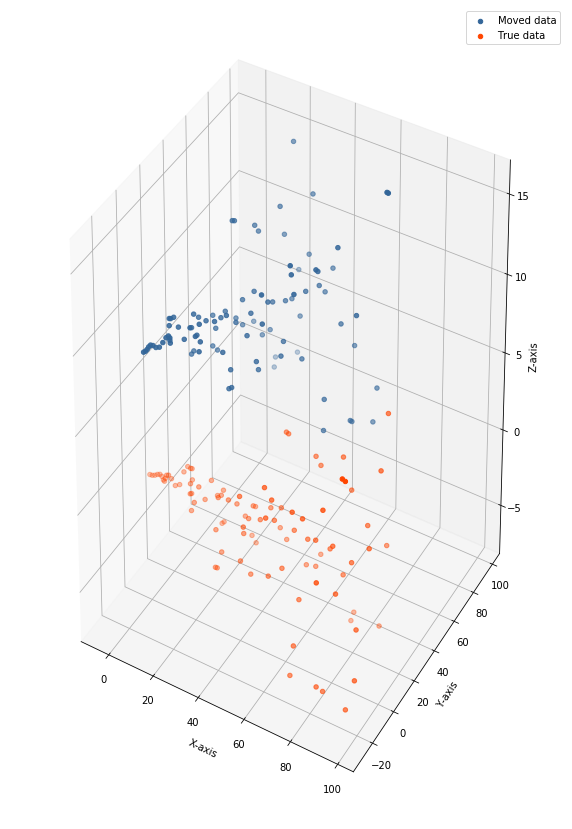

In [3]:
'''Generate data using the sin and cosine functions'''
def generateSpiral(numPoints, angle, shift):
    
    aboutZ = np.array([[math.cos(angle[2]), -math.sin(angle[2]), 0], 
                      [math.sin(angle[2]), math.cos(angle[2]), 0],
                      [0, 0, 1]])
    aboutY = np.array([[math.cos(angle[1]), 0, -math.sin(angle[1])],
                      [0, 1, 0] ,
                      [math.sin(angle[1]), 0, math.cos(angle[1])]])
    aboutX = np.array([[1, 0, 0],
                      [0, math.cos(angle[0]), -math.sin(angle[0])],
                      [0, math.sin(angle[0]), math.cos(angle[0])]])
    aboutY = np.identity(3)
    aboutX = np.identity(3)
      
    T = shift
    R = aboutZ.dot(aboutY.dot(aboutX))
    sourceData = np.zeros((3, numPoints))
    sourceData[0, :] = range(0, numPoints)
    sourceData[1, :] = 0.3 * sourceData[0, :] * np.sin(0.5 * sourceData[0, :]) 
    sourceData[2, :] = 0.3 * sourceData[1, :] * np.sin(0.5 * sourceData[1, :]) 
    
    movedData = R.dot(sourceData) + shift
    return sourceData, movedData

'''Assign data to point clouds P and Q''' 
angle = [0, 0, math.pi/3]
shift = np.array([[-5], [6], [7]])
Q, P = generateSpiral(100, angle, shift)

plot_data(P, Q, "Moved data", "True data")
plt.show()

### Identifying Corresponding Points 

In [4]:
'''For each point in the  moved data get closest points in the source data'''
def get_correspondences(P, Q):
    pSize = P.shape[1]
    qSize = Q.shape[1]
    correspondences = []
    for i in range(pSize):
        pPoint = P[:, i]
        minDist = sys.maxsize
        chosenIndex = -1
        for j in range(qSize):
            qPoint = Q[:, j]
            dist = np.linalg.norm(qPoint - pPoint)
            if dist < minDist:
                minDist = dist
                chosenIndex = j
        correspondences.append((i, chosenIndex))
    return correspondences

'''Connect the obtained corresponding points using grey lines'''
def draw_correspondences(P, Q, correspondences, ax):
    label_added = False
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        z = [P[2, i], Q[2, j]]
        if not label_added:
            ax.plot(x, y, zs=z, color='grey', label='correpondences')
            label_added = True
        else:
            ax.plot(x, y, zs=z, color='grey')
    ax.legend()

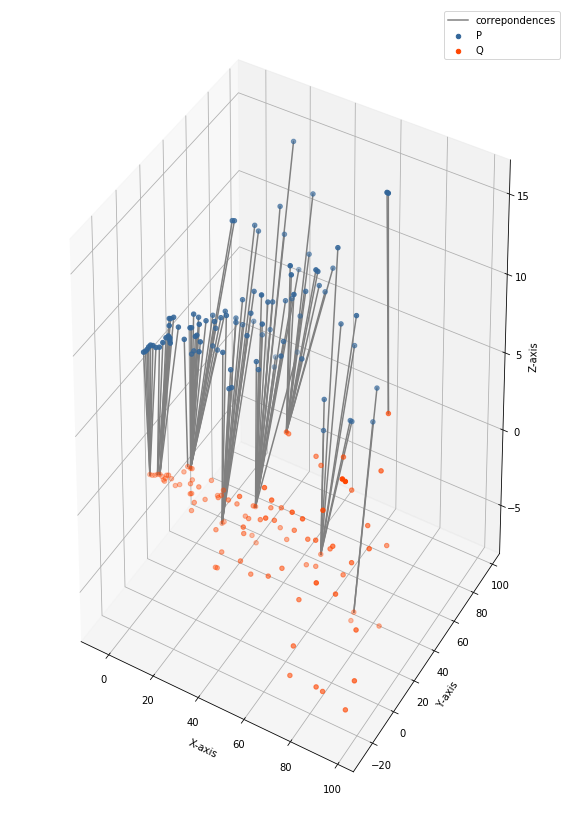

In [5]:
correspondences = get_correspondences(P, Q)
ax = plot_data(P, Q, label_1='P', label_2='Q')
draw_correspondences(P, Q, correspondences, ax)
plt.show()

In [6]:
def RotationMatrix(phi, theta, shi): #RzRyRz phi->x, theta->y, shi->z
    return Matrix(
                    [
                        [cos(shi) * cos(theta), cos(shi) * sin(theta) * sin(phi) - sin(shi) * cos(phi), cos(shi) * sin(theta) * cos(phi) + sin(shi) * sin(phi)], 
                        [sin(shi) * cos(theta), sin(shi) * sin(theta) * sin(phi) + cos(shi) * cos(phi), sin(shi) * sin(theta) * cos(phi) - cos(shi) * sin(phi)],
                        [-sin(theta), cos(theta) * sin(phi), cos(theta) * cos(phi)]
                    ]
                 )

def R(phi, theta, shi): #RzRyRz phi->x, theta->y, shi->z
    return np.array(
                    [
                        [math.cos(shi) * math.cos(theta), math.cos(shi) * math.sin(theta) * math.sin(phi) - math.sin(shi) * math.cos(phi), math.cos(shi) * math.sin(theta) * math.cos(phi) + math.sin(shi) * math.sin(phi)], 
                        [math.sin(shi) * math.cos(theta), math.sin(shi) * math.sin(theta) * math.sin(phi) + math.cos(shi) * math.cos(phi), math.sin(shi) * math.sin(theta) * math.cos(phi) - math.cos(shi) * math.sin(phi)],
                        [-math.sin(theta), math.cos(theta) * math.sin(phi), math.cos(theta) * math.cos(phi)]
                    ]
                 )

In [7]:
from sympy import init_printing, symbols, Matrix, cos, sin, diff
from IPython.display import display, Math, Latex, Markdown, HTML
from sympy import lambdify

init_printing(use_unicode = True)


x, y, z, phi, theta, shi, p_x, p_y, p_z= symbols('x, y, z, \\phi, \\theta, \\psi, p_x, p_y, p_z')


t = Matrix([[x], [y], [z]])
X = Matrix([x, y, z, phi, theta, shi])
p = Matrix([[p_x], [p_y], [p_z]])

_moved_point = RotationMatrix(phi, theta, shi) * p + t

_jacobian = diff(_moved_point, X).reshape(6, 3).transpose() #jacobian at point

display(Latex('Moved Point'), _moved_point)
display(Latex('Jacobian'), _jacobian)

<IPython.core.display.Latex object>

⎡pₓ⋅cos(\psi)⋅cos(\theta) + p_y⋅(sin(\phi)⋅sin(\theta)⋅cos(\psi) - sin(\psi)⋅c
⎢                                                                             
⎢pₓ⋅sin(\psi)⋅cos(\theta) + p_y⋅(sin(\phi)⋅sin(\psi)⋅sin(\theta) + cos(\phi)⋅c
⎢                                                                             
⎣                                       -pₓ⋅sin(\theta) + p_y⋅sin(\phi)⋅cos(\t

os(\phi)) + p_z⋅(sin(\phi)⋅sin(\psi) + sin(\theta)⋅cos(\phi)⋅cos(\psi)) + x ⎤
                                                                            ⎥
os(\psi)) + p_z⋅(-sin(\phi)⋅cos(\psi) + sin(\psi)⋅sin(\theta)⋅cos(\phi)) + y⎥
                                                                            ⎥
heta) + p_z⋅cos(\phi)⋅cos(\theta) + z                                       ⎦

<IPython.core.display.Latex object>

⎡1  0  0  p_y⋅(sin(\phi)⋅sin(\psi) + sin(\theta)⋅cos(\phi)⋅cos(\psi)) + p_z⋅(-
⎢                                                                             
⎢0  1  0  p_y⋅(-sin(\phi)⋅cos(\psi) + sin(\psi)⋅sin(\theta)⋅cos(\phi)) + p_z⋅(
⎢                                                                             
⎣0  0  1                                     p_y⋅cos(\phi)⋅cos(\theta) - p_z⋅s

sin(\phi)⋅sin(\theta)⋅cos(\psi) + sin(\psi)⋅cos(\phi))   -pₓ⋅sin(\theta)⋅cos(\
                                                                              
-sin(\phi)⋅sin(\psi)⋅sin(\theta) - cos(\phi)⋅cos(\psi))  -pₓ⋅sin(\psi)⋅sin(\th
                                                                              
in(\phi)⋅cos(\theta)                                                    -pₓ⋅co

psi) + p_y⋅sin(\phi)⋅cos(\psi)⋅cos(\theta) + p_z⋅cos(\phi)⋅cos(\psi)⋅cos(\thet
                                                                              
eta) + p_y⋅sin(\phi)⋅sin(\psi)⋅cos(\theta) + p_z⋅s

In [8]:
def compute_normals(points, step=1):
    normals = [np.array([0, 0, 0])]
    normals_at_points = []
    for i in range(step, points.shape[1] - step):
        prev_point = points[:, i - step]
        next_point = points[:, i + step]
        curr_point = points[:, i]
        a_bar = prev_point - curr_point
        b_bar = next_point - curr_point
        normal = np.cross(a_bar, b_bar)
        normal = normal / np.linalg.norm(normal)
        normals.append(normal)  
        normals_at_points.append(normal + curr_point)
    normals.append(np.array([0, 0, 0]))
    return np.array(normals), normals_at_points

In [9]:
n_x, n_y, n_z = symbols(' n_x, n_y, n_z')
n = Matrix([[n_x],[n_y], [n_z]])

_error_normal = n.dot(RotationMatrix(phi, theta, shi) * p + t)

display(Latex("Point to point Jacobian: "), _error_normal)

_jacobian_normal = diff(_error_normal, X).reshape(6, 1).transpose()

display(Latex("Point to plane Jacobian: "), _jacobian_normal)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

[nₓ  n_y  n_z  nₓ⋅(p_y⋅(sin(\phi)⋅sin(\psi) + sin(\theta)⋅cos(\phi)⋅cos(\psi))
 + p_z⋅(-sin(\phi)⋅sin(\theta)⋅cos(\psi) + sin(\psi)⋅cos(\phi))) + n_y⋅(p_y⋅(-
sin(\phi)⋅cos(\psi) + sin(\psi)⋅sin(\theta)⋅cos(\phi)) + p_z⋅(-sin(\phi)⋅sin(\
psi)⋅sin(\theta) - cos(\phi)⋅cos(\psi))) + n_z⋅(p_y⋅cos(\phi)⋅cos(\theta) - p_
z⋅sin(\phi)⋅cos(\theta))  nₓ⋅(-pₓ⋅sin(\theta)⋅cos(\psi) + p_y⋅sin(\phi)⋅cos(\p
si)⋅cos(\theta) + p_z⋅cos(\phi)⋅cos(\psi)⋅cos(\theta)) + n_y⋅(-pₓ⋅sin(\psi)⋅si
n(\theta) + p_y⋅sin(\phi)⋅sin(\psi)⋅cos(\theta) + p_z⋅sin(\psi)⋅cos(\phi)⋅cos(
\theta)) + n_z⋅(-pₓ⋅cos(\theta) - p_y⋅sin(\phi)⋅sin(\theta) - p_z⋅sin(\theta)⋅
cos(\phi))  nₓ⋅(-pₓ⋅sin(\psi)⋅cos(\theta) + p_y⋅(-sin(\phi)⋅sin(\psi)⋅sin(\the
ta) - cos(\phi)⋅cos(\psi)) + p_z⋅(sin(\phi)⋅cos(\psi) - sin(\psi)⋅sin(\theta)⋅
cos(\phi))) + n_y⋅(pₓ⋅cos(\psi)⋅cos(\theta) + p_y⋅(sin(\phi)⋅sin(\theta)⋅cos(\
psi) - sin(\psi)⋅cos(\phi)) + p_z⋅(sin(\phi)⋅sin(\psi) + sin(\theta)⋅cos(\phi)
⋅cos(\psi)))]

In [10]:
s = (phi, theta, shi, p_x, p_y, p_z, n_x, n_y, n_z)
lambda_normal_jacobian = lambdify(s, _jacobian_normal, modules='numpy')

def calculate_jacobian_normal(x, p, normal)-> np.array:
    J = lambda_normal_jacobian(*x.reshape(-1)[3:], *list(p), *normal)
    return np.array(J)

In [11]:
s = (x, y, z, phi, theta, shi, p_x, p_y, p_z)
calcuate_moved_point = lambdify(s, _moved_point, modules='numpy')

def calculate_error(x, p_point, q_point) -> np.array:
    x = x.reshape(-1)
    p_new = calcuate_moved_point(*x, *p_point)
    return p_new - q_point.reshape(3, 1)   

In [12]:
def prepare_system_normals(x, P, Q, correspondences, normals):
    H = np.zeros((6, 6))
    g = np.zeros((6, 1))
    chi = 0
    for (i, j), normal in zip(correspondences, normals):
        
        p_point, q_point = P[:, [i]], Q[:, [j]]
        
        e = normal.dot(calculate_error(x.reshape(-1), p_point.reshape(-1), q_point.reshape(-1)))
        
        J = calculate_jacobian_normal(x.reshape(-1), p_point.reshape(-1), normal.reshape(-1))
        H += J.T.dot(J)
        g += (J.T.reshape(6, 1)).dot(e.reshape(1, 1))
        chi += e.T * e
    return H, g, chi

In [13]:
def icp_normal(P, Q, normals, iterations=20):
    x = np.zeros((6, 1))
    chi_values = []
    x_values = [x.copy()]  # Initial value for transformation.
    P_values = [P.copy()]
    P_latest = P.copy()
    corresp_values = []
    for it in tqdm( range(iterations), desc ="Iteration"):
        rot = R(*x[3:])
        t = x[0:3]
        correspondences = get_correspondences(P_latest, Q)
        corresp_values.append(correspondences)
        H, g, chi = prepare_system_normals(x, P, Q, correspondences, normals)
        dx = np.linalg.lstsq(H, -g, rcond=None)[0]
        x += dx
        
#         x[2] = atan2(sin(x[2]), cos(x[2])) # normalize angle
        
        chi_values.append(chi.item(0)) # add error to list of errors
        x_values.append(x.copy())
        
        rot = R(*x[3:])
        t = x[0:3]
        P_latest = rot.dot(P.copy()) + t
        P_values.append(P_latest)
    corresp_values.append(corresp_values[-1])
    return P_values, chi_values, corresp_values

Iteration: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


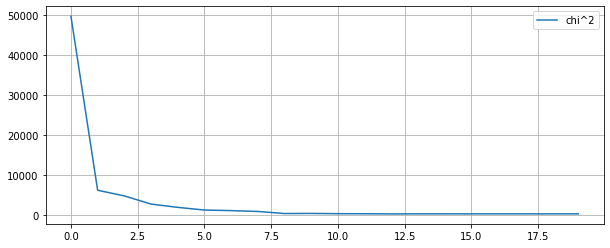

[49688.516751936724, 6189.705220575077, 4771.444096488646, 2728.8192633051585, 1908.1318333552724, 1237.7004239109363, 1094.862738246913, 887.9982712931862, 366.6962531902605, 391.01397410996174, 329.23984984532274, 312.85628153942963, 269.984691650027, 284.1257434638145, 283.26879150078366, 283.2464509122129, 283.24597277645347, 283.2459602297115, 283.2459599001208, 283.2459598914619]


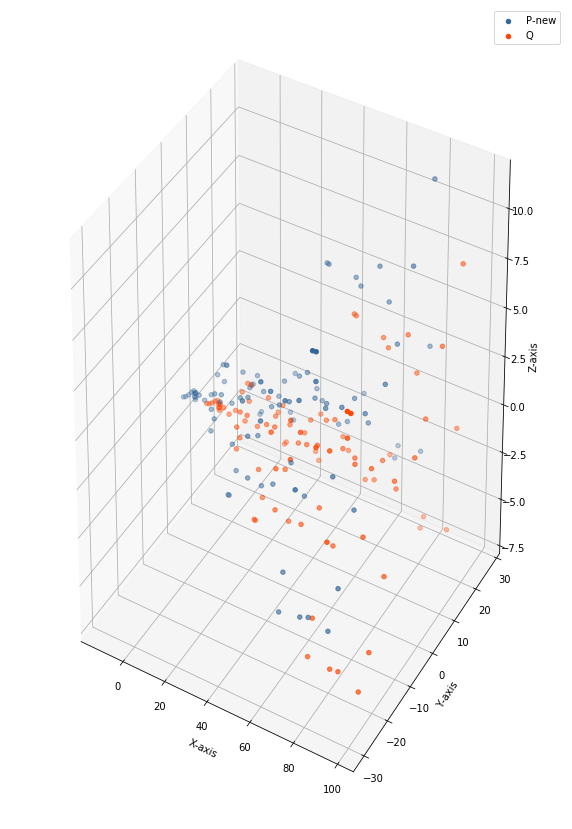

In [14]:
normals, normals_to_draw = compute_normals(Q)

P_values, chi_values, corresp_values = icp_normal(P, Q, normals)
plot_values(chi_values, label="chi^2")
print(chi_values)
ax = plot_data(P_values[-1], Q, label_1='P-new', label_2='Q')
plt.show()
